In [38]:
import time
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import matplotlib.pyplot as plt

In [39]:
BATCH_SIZE = 256

In [130]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(66),
    tv.transforms.ToTensor()
])

In [131]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.FashionMNIST('.', train=False, transform=transforms, download=True)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [132]:
print(train_dataset[0][0].shape, train_dataset[0][1])
# print(train_dataset[0][0].numpy().reshape(32,32)[15, 10:20])

torch.Size([1, 66, 66]) 9


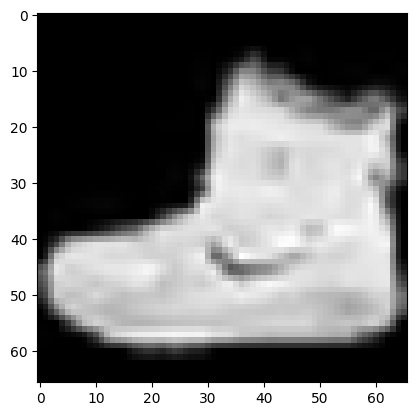

In [133]:
plt.imshow(train_dataset[0][0].numpy().reshape(66,66), cmap='gray')

In [147]:
model = nn.Sequential(
    # inp 66 out 66-7+1=60
    nn.Conv2d(1, 6, kernel_size=7, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # inp 30 out 30-7+1=24
    nn.Conv2d(6, 18, kernel_size=7, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # inp 12 out 12-7+1=6
    nn.Conv2d(18, 90, kernel_size=7, padding=0),
    nn.Tanh(), # [1, 90, 6, 6]
    nn.AvgPool2d(kernel_size=2, stride=2),
    # inp 3 out 1
    nn.Conv2d(90, 120, kernel_size=3), 
    nn.Flatten(),
    nn.Linear(120,84),
    nn.Tanh(),
    # nn.Dropout(0.5),
    nn.Linear(84,10)
)

In [148]:
# try first image from dataset
X = train_dataset[0][0].reshape(1,1,66,66)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))


torch.Size([1, 1, 66, 66])
Layer Conv2d(1, 6, kernel_size=(7, 7), stride=(1, 1)). X shape: torch.Size([1, 6, 60, 60])
Layer Tanh(). X shape: torch.Size([1, 6, 60, 60])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X shape: torch.Size([1, 6, 30, 30])
Layer Conv2d(6, 18, kernel_size=(7, 7), stride=(1, 1)). X shape: torch.Size([1, 18, 24, 24])
Layer Tanh(). X shape: torch.Size([1, 18, 24, 24])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X shape: torch.Size([1, 18, 12, 12])
Layer Conv2d(18, 90, kernel_size=(7, 7), stride=(1, 1)). X shape: torch.Size([1, 90, 6, 6])
Layer Tanh(). X shape: torch.Size([1, 90, 6, 6])
Layer AvgPool2d(kernel_size=2, stride=2, padding=0). X shape: torch.Size([1, 90, 3, 3])
Layer Conv2d(90, 120, kernel_size=(3, 3), stride=(1, 1)). X shape: torch.Size([1, 120, 1, 1])
Layer Flatten(start_dim=1, end_dim=-1). X shape: torch.Size([1, 120])
Layer Linear(in_features=120, out_features=84, bias=True). X shape: torch.Size([1, 84])
Layer Tanh(). X shape: torch

In [149]:
summary(model, input_size=(1, 66, 66))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             300
              Tanh-2            [-1, 6, 60, 60]               0
         AvgPool2d-3            [-1, 6, 30, 30]               0
            Conv2d-4           [-1, 18, 24, 24]           5,310
              Tanh-5           [-1, 18, 24, 24]               0
         AvgPool2d-6           [-1, 18, 12, 12]               0
            Conv2d-7             [-1, 90, 6, 6]          79,470
              Tanh-8             [-1, 90, 6, 6]               0
         AvgPool2d-9             [-1, 90, 3, 3]               0
           Conv2d-10            [-1, 120, 1, 1]          97,320
          Flatten-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             Tanh-13                   [-1, 84]               0
           Linear-14                   

In [150]:
X = train_dataset[0][0].reshape(1,1,66,66)
y = model(X)
y.shape

torch.Size([1, 10])

In [77]:
def eval_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        # X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
        # if n % 200 == 0:
        #     print('y.shape[0]={}, n={}'.format(y.shape[0], n))
    return acc_sum.item() / n

In [84]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    # net.to(device)
    # loss = nn.CrossEntropyLoss(reduction='sum')
    loss = nn.CrossEntropyLoss(reduction='mean')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n =  0.0, 0.0, 0 
        start =time.time()
        
        for i, (X, y) in enumerate(train_iter):
            # X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            # if i % 100 == 0:
            #   print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
            #         f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")

        # test_acc = eval_accuracy(test_iter, net.to(device))
        test_acc = eval_accuracy(test_iter, net)
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [151]:
# trainer = torch.optim.Adam(net.parameters(), lr=0.1)
trainer = torch.optim.SGD(model.parameters(), lr=0.1)
train(model, train_dl, test_dl, trainer, num_epochs=30)

--------------------
epoch 1, loss 0.0042, train acc 0.599, test acc 0.723, time 39.7 sec
--------------------
epoch 2, loss 0.0024, train acc 0.765, test acc 0.782, time 45.4 sec
--------------------
epoch 3, loss 0.0020, train acc 0.806, test acc 0.808, time 40.6 sec
--------------------
epoch 4, loss 0.0018, train acc 0.832, test acc 0.824, time 42.0 sec
--------------------
epoch 5, loss 0.0017, train acc 0.846, test acc 0.832, time 42.4 sec
--------------------
epoch 6, loss 0.0015, train acc 0.856, test acc 0.839, time 42.2 sec
--------------------
epoch 7, loss 0.0015, train acc 0.864, test acc 0.847, time 42.8 sec
--------------------
epoch 8, loss 0.0014, train acc 0.869, test acc 0.854, time 40.3 sec
--------------------
epoch 9, loss 0.0013, train acc 0.874, test acc 0.860, time 41.3 sec
--------------------
epoch 10, loss 0.0013, train acc 0.879, test acc 0.866, time 42.5 sec
--------------------
epoch 11, loss 0.0012, train acc 0.883, test acc 0.871, time 42.9 sec
--------